In [2]:
import pandas as pd 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,make_scorer,f1_score,precision_score,recall_score,roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('./datasets/classification/titanic.csv')

print(data.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

In [8]:
print(data.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [9]:
# target dataframe: data
target = "Survived"
features = list(data.columns.drop("Survived"))
feature_df = data[features]

prediction_df = data

# get numerical and categorical columns
bool_cols = feature_df.select_dtypes(include=['bool']).columns.tolist()
data[bool_cols] = feature_df[bool_cols].astype(int)
numerical_cols = feature_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = feature_df.select_dtypes(include=['object']).columns.tolist()
text_cols = feature_df.select_dtypes(include=['string']).columns.tolist()


sample_size = np.min([10000, data.shape[0]])
unique_theshold = np.min([100, sample_size/10])

# check categorical columns for high cardinality and make it text column
for col in categorical_cols:
    if data[col].sample(sample_size).nunique() > unique_theshold:
        text_cols.append(col)
        categorical_cols.remove(col)
        

# check text columns for low cardinality and make it categorical columns
for col in text_cols:
    if data[col].sample(sample_size).nunique() < unique_theshold:
        categorical_cols.append(col)
        text_cols.remove(col)

print(numerical_cols)
print(categorical_cols)
print(text_cols)

# define numeric transformer steps
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", MinMaxScaler())]
)

# define categorical transformer steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# define text transformer steps
text_transformer = Pipeline(
    steps=[
        ('text', TfidfVectorizer())
    ]
)

# create the preprocessing pipelines for both numeric and categorical data
preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer , numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        *[(f'text_{t_col}', text_transformer, t_col) for t_col in text_cols]]
)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Sex', 'Cabin', 'Embarked']
['Name', 'Ticket']


In [10]:
# train test split
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_comparison_list = []

In [16]:

xgboost_classifier_param_grid = {
"xgboost_classifier__learning_rate": np.arange(0.1, 1.0, 0.25),
"xgboost_classifier__n_estimators": np.arange(1, 5, 1),
"xgboost_classifier__max_depth": np.arange(1, 2, 1),
"xgboost_classifier__gamma": np.arange(0.0, 0.5, 0.25),
"xgboost_classifier__subsample": np.arange(0.1, 1.0, 0.25),
"xgboost_classifier__colsample_bytree": np.arange(0.5, 1.0, 0.25),
}


# Create the pipeline
xgboost_classifier_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('xgboost_classifier', XGBClassifier())
])

# Create the grid search
xgboost_classifier_grid_search = GridSearchCV(estimator=xgboost_classifier_pipe, param_grid=xgboost_classifier_param_grid, cv=2, scoring=make_scorer(accuracy_score), verbose=3)
xgboost_classifier_grid_search.fit(X_train, y_train)



Fitting 2 folds for each of 256 candidates, totalling 512 fits
[CV 1/2] END xgboost_classifier__colsample_bytree=0.5, xgboost_classifier__gamma=0.0, xgboost_classifier__learning_rate=0.1, xgboost_classifier__max_depth=1, xgboost_classifier__n_estimators=1, xgboost_classifier__subsample=0.1;, score=0.671 total time=   0.0s
[CV 2/2] END xgboost_classifier__colsample_bytree=0.5, xgboost_classifier__gamma=0.0, xgboost_classifier__learning_rate=0.1, xgboost_classifier__max_depth=1, xgboost_classifier__n_estimators=1, xgboost_classifier__subsample=0.1;, score=0.764 total time=   0.0s
[CV 1/2] END xgboost_classifier__colsample_bytree=0.5, xgboost_classifier__gamma=0.0, xgboost_classifier__learning_rate=0.1, xgboost_classifier__max_depth=1, xgboost_classifier__n_estimators=1, xgboost_classifier__subsample=0.35;, score=0.671 total time=   0.0s
[CV 2/2] END xgboost_classifier__colsample_bytree=0.5, xgboost_classifier__gamma=0.0, xgboost_classifier__learning_rate=0.1, xgboost_classifier__max_dept

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['PassengerId',
                                                                          'Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_...
             param_grid={'xgboost_classifier__colsample_bytree': array([0.5 , 0.75]),
                         'xgboost_classifier__gamma': array([0.  , 0.25]),
                         'xgboost_classifier__learning_rate': array([0.1 , 0.35, 0.6 , 0.85]),
                         'xgboost_classifier__max_depth': array([1]),
                         'xgboost_classifier__n_estimators': array([1, 2, 3, 4]),
                         'xgboost_classifier__subsample': array([0.1 , 0.35, 0.6 , 0.85])},
             scoring=make_scorer(accuracy_score), verbose=3)

In [17]:
# Get the best hyperparameters
xgboost_classifier_best_estimator = xgboost_classifier_grid_search.best_estimator_

# Store results as a dataframe  
xgboost_classifier_search_results = pd.DataFrame(xgboost_classifier_grid_search.cv_results_)

print(xgboost_classifier_search_results)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.027504      0.002497         0.017757    2.429485e-04   
1         0.029003      0.000002         0.017257    2.564192e-04   
2         0.034533      0.000533         0.020004    1.996517e-03   
3         0.032254      0.000257         0.018004    3.218651e-06   
4         0.031755      0.000244         0.018258    1.257062e-03   
..             ...           ...              ...             ...   
251       0.035500      0.001500         0.019755    1.245975e-03   
252       0.034256      0.000255         0.020504    4.969835e-04   
253       0.035759      0.000760         0.018505    5.050898e-04   
254       0.033504      0.000495         0.019261    1.259565e-03   
255       0.036259      0.002742         0.020001    9.536743e-07   

    param_xgboost_classifier__colsample_bytree  \
0                                          0.5   
1                                          0.5   
2                    

                model         metric     value
4  xgboost_classifier  roc_auc_score  0.835457


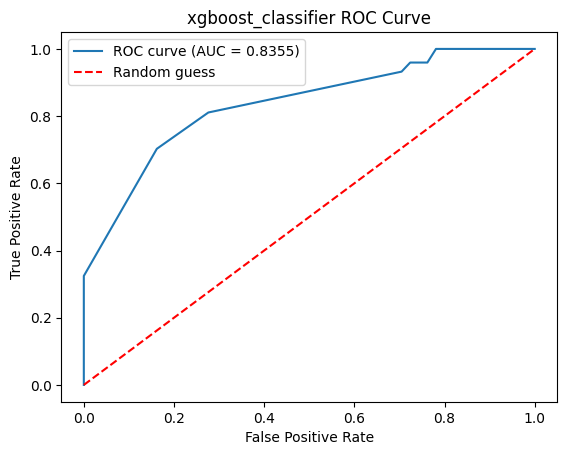

In [18]:
# Model metrics

# Generate Predictions
xgboost_classifier_predictions = pd.DataFrame(xgboost_classifier_best_estimator.predict(X_test))

xgboost_classifier_predictions_prob = xgboost_classifier_best_estimator.predict_proba(X_test)
xgboost_classifier_predictions_prob_df = pd.DataFrame()
xgboost_classifier_predictions_prob_df[xgboost_classifier_grid_search.classes_[0]] = xgboost_classifier_predictions_prob[:,0]
xgboost_classifier_predictions_prob_df[xgboost_classifier_grid_search.classes_[1]] = xgboost_classifier_predictions_prob[:,1] 


# Generate Model Metrics
xgboost_classifier_accuracy = accuracy_score(y_test, xgboost_classifier_predictions.iloc[:,0])
xgboost_classifier_f1_score = f1_score(y_test, xgboost_classifier_predictions.iloc[:,0])
xgboost_classifier_precision = precision_score(y_test, xgboost_classifier_predictions.iloc[:,0])
xgboost_classifier_recall = recall_score(y_test, xgboost_classifier_predictions.iloc[:,0])
xgboost_classifier_roc_auc_score = roc_auc_score(y_test, xgboost_classifier_predictions_prob_df[xgboost_classifier_grid_search.classes_[1]])
xgboost_classifier_performance_metrics = [['xgboost_classifier','accuracy',xgboost_classifier_accuracy], 
                                  ['xgboost_classifier','f1_score',xgboost_classifier_f1_score],
                                  ['xgboost_classifier','precision', xgboost_classifier_precision],
                                  ['xgboost_classifier','recall', xgboost_classifier_recall],
                                  ['xgboost_classifier','roc_auc_score', xgboost_classifier_roc_auc_score]]
xgboost_classifier_performance_metrics = pd.DataFrame(xgboost_classifier_performance_metrics, columns=['model','metric', 'value'])
fpr, tpr, thresholds = roc_curve(y_test, xgboost_classifier_predictions_prob_df[xgboost_classifier_grid_search.classes_[1]])
roc_auc = auc(fpr, tpr)

# ROC Curve plot
xgboost_classifier_roc_auc_plot, xgboost_classifier_roc_auc_plot_ax = plt.subplots()
xgboost_classifier_roc_auc_plot_ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
xgboost_classifier_roc_auc_plot_ax.plot([0, 1], [0, 1], 'r--', label='Random guess')
# Set axis labels and title
xgboost_classifier_roc_auc_plot_ax.set_xlabel('False Positive Rate')
xgboost_classifier_roc_auc_plot_ax.set_ylabel('True Positive Rate')
xgboost_classifier_roc_auc_plot_ax.set_title(f'xgboost_classifier ROC Curve')
# Add legend
xgboost_classifier_roc_auc_plot_ax.legend()


print(xgboost_classifier_performance_metrics[xgboost_classifier_performance_metrics['metric'] == 'roc_auc_score'])

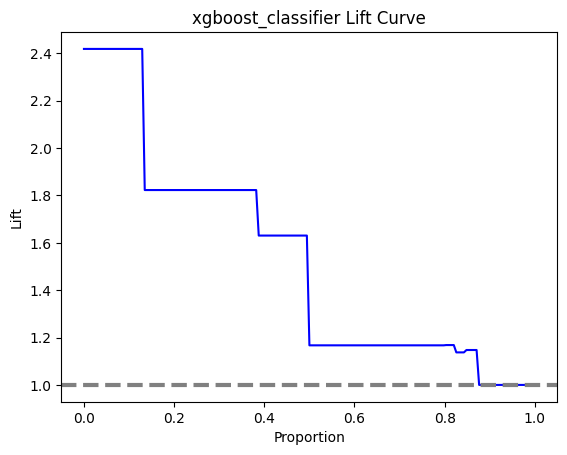

In [19]:
# Lift Chart
aux_df = pd.DataFrame()
aux_df['y_real'] = y_test
aux_df['y_proba'] = xgboost_classifier_predictions_prob_df.iloc[:,1].values

# Sort by predicted probability
aux_df = aux_df.sort_values('y_proba', ascending=False)

# Find the total positive ratio of the whole dataset
total_positive_ratio = sum(aux_df['y_real'] == 1) / aux_df.shape[0]

# For each line of data, get the ratio of positives of the given subset and calculate the lift
lift_values = []
for i in aux_df.index:
    threshold = aux_df.loc[i]['y_proba']
    subset = aux_df[aux_df['y_proba'] >= threshold]
    subset_positive_ratio = sum(subset['y_real'] == 1) / subset.shape[0]
    lift = subset_positive_ratio / total_positive_ratio
    lift_values.append(lift)

# Plot the lift curve
xgboost_classifier_lift_plot, xgboost_classifier_lift_plot_ax = plt.subplots()
xgboost_classifier_lift_plot_ax.set_xlabel('Proportion')
xgboost_classifier_lift_plot_ax.set_ylabel('Lift')
xgboost_classifier_lift_plot_ax.set_title(f'xgboost_classifier Lift Curve')

# plot the lift curve
x_vals = np.linspace(0, 1, num=len(lift_values))
xgboost_classifier_lift_plot_ax.plot(x_vals, lift_values, color='b')

# add dashed horizontal line at lift of 1
xgboost_classifier_lift_plot_ax.axhline(y=1, color='gray', linestyle='--', linewidth=3)